# Introduction
Imagine it is sunday night and you are exhausted of you weekend as usual.
You have only 2 things in your mind: 1) order sushi and 2) find a very good movie to go with it.
Sushi has been taken care of, you only have to find a good movie.
Now, suppose that according to our criteria, a good movie should correspond to at least a rating of 8 in 
[IMDB](https://www.imdb.com/).
Let us build a model that will be able to predict the IMDB rating of movies based on theis metadatas.
Note that comments are available throughout the use case so that you can follow along.

In [132]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth",200)

%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import ADASYN 

from typing import List
from typing import Iterable
from typing import Tuple


# Data description

In [2]:
# Load the data about the movies and their metadata
df_full = pd.read_csv("data/movie_metadata_100_years.csv")
print(df_full.shape)
df_full.head()

(4829, 28)


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pirate|singapore,http://www.imdb.com/title/tt0449088/?ref_=fn_tt_tt_1,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_tt_tt_1,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police officer|terrorist plot,http://www.imdb.com/title/tt1345836/?ref_=fn_tt_tt_1,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,Daryl Sabara,John Carter,212204,1873,Polly Walker,1.0,alien|american civil war|male nipple|mars|princess,http://www.imdb.com/title/tt0401729/?ref_=fn_tt_tt_1,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000


In [3]:
df_full.describe(include="all")

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4815,4829,4790.000000,4817.000000,4829.000000,4811.000000,4819,4822.000000,4.082000e+03,4829,4822,4829,4.829000e+03,4829.000000,4811,4819.000000,4708,4829,4815.000000,4821,4828,4582,4.450000e+03,4829.000000,4819.000000,4829.000000,4543.000000,4829.000000
unique,2,2353,NaN,NaN,NaN,NaN,2916,NaN,NaN,883,2012,4713,NaN,NaN,3386,NaN,4589,4715,NaN,47,64,15,NaN,NaN,NaN,NaN,NaN,NaN
top,Color,Steven Spielberg,NaN,NaN,NaN,NaN,Morgan Freeman,NaN,NaN,Drama,Robert De Niro,The Fast and the Furious,NaN,NaN,Ben Mendelsohn,NaN,one word title,http://www.imdb.com/title/tt0232500/?ref_=fn_tt_tt_1,NaN,English,USA,R,NaN,NaN,NaN,NaN,NaN,NaN
freq,4609,25,NaN,NaN,NaN,NaN,19,NaN,NaN,226,47,3,NaN,NaN,8,NaN,3,3,NaN,4508,3656,2086,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,142.330271,108.135146,694.858563,650.613594,NaN,6590.376607,4.798792e+07,NaN,NaN,NaN,8.597468e+04,9746.424933,NaN,1.355053,NaN,NaN,278.488681,NaN,NaN,NaN,3.945645e+07,2002.173535,1659.787508,6.417995,2.123396,7374.747774
std,NaN,NaN,121.155462,22.647858,2836.545243,1681.307008,NaN,14816.678327,6.782089e+07,NaN,NaN,NaN,1.405698e+05,18037.845420,NaN,2.002256,NaN,NaN,380.584203,NaN,NaN,NaN,2.082184e+08,12.446893,4066.749765,1.113503,0.768813,19126.154644
min,NaN,NaN,1.000000,7.000000,0.000000,0.000000,NaN,0.000000,1.620000e+02,NaN,NaN,NaN,5.000000e+00,0.000000,NaN,0.000000,NaN,NaN,1.000000,NaN,NaN,NaN,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,NaN,NaN,53.000000,94.000000,7.000000,133.000000,NaN,617.000000,5.220278e+06,NaN,NaN,NaN,9.280000e+03,1414.000000,NaN,0.000000,NaN,NaN,69.000000,NaN,NaN,NaN,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,NaN,NaN,112.000000,104.000000,49.000000,374.000000,NaN,990.500000,2.524284e+07,NaN,NaN,NaN,3.584800e+04,3107.000000,NaN,1.000000,NaN,NaN,162.000000,NaN,NaN,NaN,2.000000e+07,2005.000000,597.000000,6.500000,2.350000,158.000000
75%,NaN,NaN,196.000000,118.000000,197.000000,637.000000,NaN,11000.000000,6.123895e+07,NaN,NaN,NaN,9.917700e+04,13917.000000,NaN,2.000000,NaN,NaN,335.000000,NaN,NaN,NaN,4.400000e+07,2010.000000,920.000000,7.200000,2.350000,3000.000000


In [4]:
df_full.dtypes

color                         object
director_name                 object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
gross                        float64
genres                        object
actor_1_name                  object
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
actor_3_name                  object
facenumber_in_poster         float64
plot_keywords                 object
movie_imdb_link               object
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64
aspect_ratio                 float64
m

# Explore the target(s) 
In this section, we explore our target(s): 
- The IMDB score (continuous variable) and 
- The class of good and less good movies (which is a calculated target from the first target).


Missing value in the target: 0
Distribution of the data:



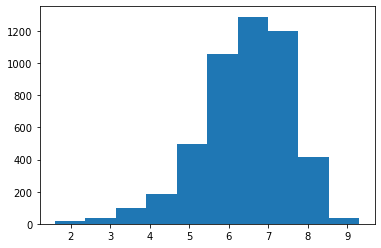

In [5]:
# Explore the distribution of the target
print("Missing value in the target:", df_full['imdb_score'].isna().sum())
print("Distribution of the data:\n")
graph = plt.hist(list(df_full['imdb_score']))


In [6]:
# Compute classes, for reminder, a very good movie has an IMDB of 8 or more
df_full['target_imdb_score_regression'] = df_full['imdb_score']
df_full['target_imdb_score_classification'] = df_full['imdb_score'].map(lambda x: 1 if x>=8.0 else 0)


In [7]:
# Are the classes unbalances?
value_counts = df_full['target_imdb_score_classification'].value_counts()
print(f'The proportion of the 2 classes:\n'+ 
      f'- Class 0: {value_counts[0]/sum(value_counts)}\n'+
      f'- Class 1: {value_counts[1]/sum(value_counts)}')


# Yes, they are!

The proportion of the 2 classes:
- Class 0: 0.9409815696831643
- Class 1: 0.059018430316835784


In [8]:
# Now that we have handled the target, we may delete the raw column
df_full = df_full.drop(columns=["imdb_score"], inplace=False)

# Data Exploration & Data Wrangling & Feature Engineering
In this section, we explore and visualize the dataset.
Particularly, we clean the data, see its correlation with the target and extract features that will help building a good model.

## Explore the feature "title_year"

In [9]:
# Compute the missing values
print(f'The number of mission values is: {df_full["title_year"].isna().sum()}')
print(f'The proportion of mission values is: {df_full["title_year"].isna().mean()}')


The number of mission values is: 0
The proportion of mission values is: 0.0


2011.0    225
2012.0    221
2013.0    237
2014.0    252
2015.0    226
Name: title_year, dtype: int64

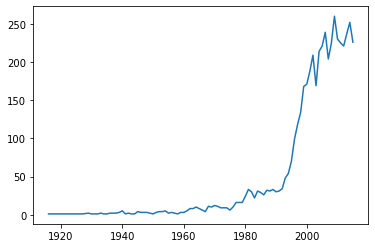

In [10]:
# Show the variation over the years, the number of movies increaces with time
value_counts = df_full["title_year"].value_counts()
value_counts = value_counts.sort_index()
plt.plot(value_counts.index, value_counts)
value_counts.tail()

In [11]:
# Fill missing values with median
df_full["fe_title_year"] = df_full["title_year"].fillna(df_full["title_year"].median())
df_full["fe_title_year"] = df_full["fe_title_year"].astype("int")

In [12]:
# Group years
min_year = df_full["fe_title_year"].min() - 1
max_year = df_full["fe_title_year"].max() + 1
df_full["fe_title_year_grouped"] = pd.cut(df_full["fe_title_year"], 
                                          bins = [min_year, 1960, 1970, 1980, 1990, 2000, 2010, max_year], 
       labels =["0000", "1960", "1970", "1980", "1990", "2000", "2010"])


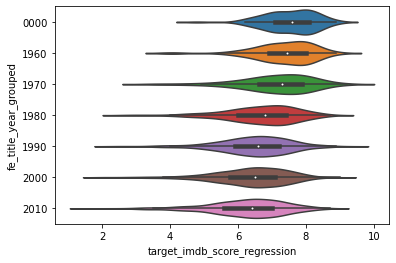

In [13]:
# The average movie score is getting worse. Some may certainly agree that it was better in the old good times!
graph = sns.violinplot(x='target_imdb_score_regression', y='fe_title_year_grouped', data=df_full)


In [14]:
# Since it is an ordinal feature, let us "cast back" to number
df_full["fe_title_year_grouped"] = df_full["fe_title_year_grouped"].astype('int')

In [15]:
# Now that we have handled this feature, we may delete the raw columns
df_full = df_full.drop(columns=["title_year"], inplace=False)
df_full = df_full.drop(columns=["fe_title_year"], inplace=False)

## Explore the feature "num_critic_for_reviews"

In [16]:
# Compute the missing values
print(f'The number of mission values is: {df_full["num_critic_for_reviews"].isna().sum()}')
print(f'The proportion of mission values is: {df_full["num_critic_for_reviews"].isna().mean()}')


The number of mission values is: 39
The proportion of mission values is: 0.008076206253882792


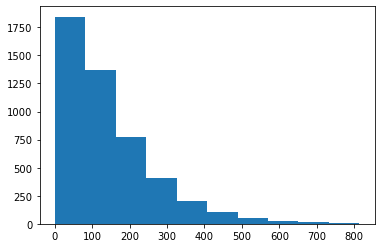

In [17]:
graph = plt.hist(df_full["num_critic_for_reviews"])


In [18]:
# Fill this feature with the median value as it is skewed
df_full["fe_num_critic_for_reviews"] = df_full["num_critic_for_reviews"].fillna(
    df_full["num_critic_for_reviews"].median())


In [19]:
# Now that we have handled this feature, we may delete the raw columns
df_full = df_full.drop(columns=["num_critic_for_reviews"], inplace=False)

## Explore the feature "num_user_for_reviews"

In [20]:
# Compute the missing values
print(f'The number of mission values is: {df_full["num_user_for_reviews"].isna().sum()}')
print(f'The proportion of mission values is: {df_full["num_user_for_reviews"].isna().mean()}')


The number of mission values is: 14
The proportion of mission values is: 0.002899150962932284


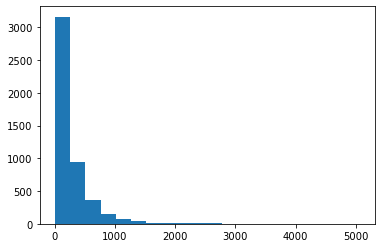

In [21]:
graph = plt.hist(df_full["num_user_for_reviews"], bins=20)


In [22]:
# Fill this feature with the median value as it is skewed
df_full["fe_num_user_for_reviews"] = df_full["num_user_for_reviews"].fillna(
    df_full["num_user_for_reviews"].median())

In [23]:
# Now that we have handled this feature, we may delete the raw columns
df_full = df_full.drop(columns=["num_user_for_reviews"], inplace=False)

## Explore the feature "content_rating"

In [24]:
# Compute the missing values
print(f'The number of mission values is: {df_full["content_rating"].isna().sum()}')
print(f'The proportion of mission values is: {df_full["content_rating"].isna().mean()}')


The number of mission values is: 247
The proportion of mission values is: 0.051149306274591015


In [25]:
value_counts = df_full["content_rating"].value_counts()
value_counts

R            2086
PG-13        1415
PG            689
Not Rated     113
G             112
Unrated        62
Approved       55
X              13
Passed          9
NC-17           7
GP              6
M               5
TV-G            4
TV-PG           3
TV-14           3
Name: content_rating, dtype: int64

In [26]:
# We observe that there are 2 similiar categories, we have to group them "manually"
# By the was, more about the movie rating system in the following link
# https://en.wikipedia.org/wiki/Motion_Picture_Association_film_rating_system
value_counts["Unrated"] = value_counts["Unrated"] + value_counts["Not Rated"]
value_counts = value_counts.drop(labels=['Not Rated'])

In [27]:
value_counts = value_counts[value_counts>100]

def group_small_categories(x):
    if(x not in(value_counts.index)):
        return "Other"
    return x

df_full["fe_content_rating"] = df_full["content_rating"].map(lambda x: group_small_categories(x))

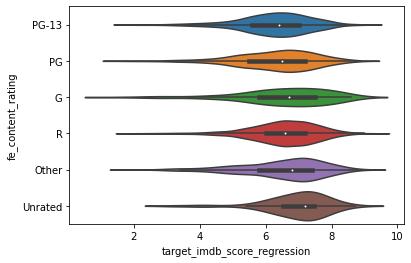

In [28]:
graph = sns.violinplot(x='target_imdb_score_regression', y='fe_content_rating', data=df_full)


In [29]:
# One hot encore this feature
df_full["fe_content_rating"] = df_full["fe_content_rating"].astype("category")
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df_full[["fe_content_rating"]])

print(f' The categories are: {enc.categories_}')
enc_df = pd.DataFrame(enc.transform(df_full[["fe_content_rating"]]).toarray(),
                     columns = enc.get_feature_names(['fe_is_content_rating'])
                     )
df_full = df_full.join(enc_df)

 The categories are: [array(['G', 'Other', 'PG', 'PG-13', 'R', 'Unrated'], dtype=object)]


In [30]:
# Now that we have handled this feature, we may delete the raw columns
df_full = df_full.drop(columns=["content_rating"], inplace=False)
df_full = df_full.drop(columns=["fe_content_rating"], inplace=False)


## Explore the feature "budget"

In [31]:
# Compute the missing values
print(f'The number of mission values is: {df_full["budget"].isna().sum()}')
print(f'The proportion of mission values is: {df_full["budget"].isna().mean()}')


The number of mission values is: 379
The proportion of mission values is: 0.07848415821080969


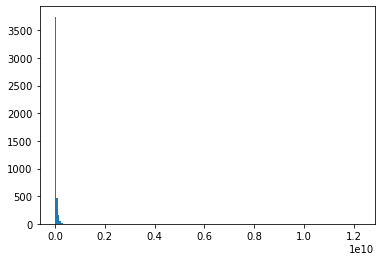

In [32]:
graph = plt.hist(df_full["budget"], bins=200)


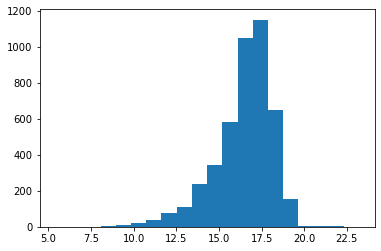

In [33]:
# Let us use the log of budget instead
graph = plt.hist(np.log(df_full["budget"] + 1), bins=20)


In [34]:
# Fill this feature with the median value as it is skewed
df_full["fe_budget"] = df_full["budget"].fillna(df_full["budget"].median())

# Let us compute the log of the feature
df_full["fe_budget_log"] = df_full["fe_budget"].map(lambda x: np.log(x + 1))

In [35]:
# Now that we have handled this feature, we may delete the raw columns
df_full = df_full.drop(columns=["budget"], inplace=False)
df_full = df_full.drop(columns=["fe_budget"], inplace=False)

## Explore the feature "facenumber_in_poster"

In [36]:
# Compute the missing values
print(f'The number of mission values is: {df_full["facenumber_in_poster"].isna().sum()}')
print(f'The proportion of mission values is: {df_full["facenumber_in_poster"].isna().mean()}')


The number of mission values is: 10
The proportion of mission values is: 0.0020708221163802027


In [37]:
df_full["facenumber_in_poster"].value_counts().head(10)

0.0    2067
1.0    1211
2.0     683
3.0     366
4.0     190
5.0     106
6.0      72
7.0      47
8.0      33
9.0      15
Name: facenumber_in_poster, dtype: int64

In [38]:
#  Keep only the number with the minimum of occurrences
df_full["fe_facenumber_in_poster"] = df_full["facenumber_in_poster"].map(lambda x: int(x) if x<=6 else 6)


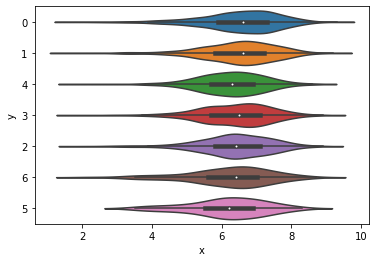

In [39]:
# There is appearently no correlation
graph = sns.violinplot(x='x', y='y', data=pd.DataFrame({
    "x": df_full['target_imdb_score_regression'],
    "y": df_full['fe_facenumber_in_poster'].astype('str'),
}))


In [40]:
# Now that we have handled this feature, we may delete the raw columns
df_full = df_full.drop(columns=["facenumber_in_poster"], inplace=False)

## Explore the feature "aspect_ratio"

In [41]:
# Compute the missing values
print(f'The number of mission values is: {df_full["aspect_ratio"].isna().sum()}')
print(f'The proportion of mission values is: {df_full["aspect_ratio"].isna().mean()}')


The number of mission values is: 286
The proportion of mission values is: 0.05922551252847381


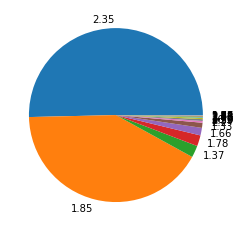

In [42]:
values_counts = df_full["aspect_ratio"].value_counts()

fig1, ax1 = plt.subplots()
ax1.pie(values_counts.values, labels=values_counts.index)
plt.show()

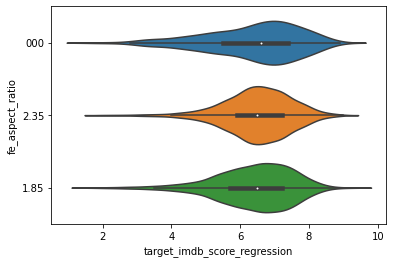

In [43]:
# Visualize the distribution of the IMDB according the the aspect ratio (after grouping small categories)
def group_small_categories(x):
    if((x!=2.35) & (x!=1.85)):
        return "000"
    else:
        return str(x)
df_full["fe_aspect_ratio"] = df_full["aspect_ratio"].map(lambda x: group_small_categories(x))

graph = sns.violinplot(x='target_imdb_score_regression', y='fe_aspect_ratio', data=df_full)


In [44]:
# We do not see a correlation, and the distribution seems fairly evec between the different categories. 
# Let us keep this feature anyway in case there is complex correlation with other features.

# Let us "one hot encode" this feature (and grouping the small categories, and the empty category)
df_full["fe_is_aspect_ratio_235"] = df_full["aspect_ratio"].map(lambda x: 1 if x==2.35 else 0)
df_full["fe_is_aspect_ratio_185"] = df_full["aspect_ratio"].map(lambda x: 1 if x==1.85 else 0)
df_full["fe_is_aspect_ratio_000"] = df_full["aspect_ratio"].map(lambda x: 1 if ((x!=2.35) & (x!=1.85)) else 0)


In [45]:
# Now that we have handled this feature, we may delete the raw columns
df_full = df_full.drop(columns=["aspect_ratio"], inplace=False)
df_full = df_full.drop(columns=["fe_aspect_ratio"], inplace=False)

## Explore the feature "language"

In [46]:
# Compute the missing values
print(f'The number of mission values is: {df_full["language"].isna().sum()}')
print(f'The proportion of mission values is: {df_full["language"].isna().mean()}')


The number of mission values is: 8
The proportion of mission values is: 0.0016566576931041624


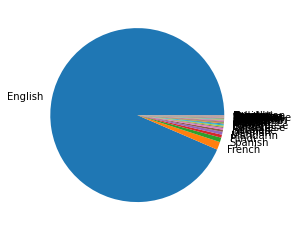

In [47]:
# Visualize the share of the market with regards to the language
values_counts = df_full["language"].value_counts()

fig1, ax1 = plt.subplots()
ax1.pie(values_counts.values, labels=values_counts.index)
plt.show()

In [48]:
# We see that there is only the "English" and "French" language that represent more than 10%
values_counts = df_full["language"].value_counts(normalize = True)
values_counts[values_counts > 0.01]

English    0.935076
French     0.014727
Name: language, dtype: float64

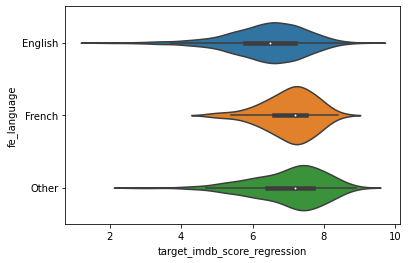

In [49]:
# Group the languages with little occurrences into one category
def get_language(x):
    if((x!="English") & (x!="French")):
        return "Other"
    return x

df_full["fe_language"] = df_full["language"].map(lambda x: get_language(x))

# Visualize the distribution of the IMDB according the the aspect ratio (after grouping small categories)
graph = sns.violinplot(x='target_imdb_score_regression', y='fe_language', data=df_full)

In [50]:
# One hot encore this feature
df_full["fe_language"] = df_full["fe_language"].astype("category")
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df_full[["fe_language"]])

print(f' The categories are: {enc.categories_}')
enc_df = pd.DataFrame(enc.transform(df_full[["fe_language"]]).toarray(),
                     columns = enc.get_feature_names(['fe_is_language'])
                     )
df_full = df_full.join(enc_df)


 The categories are: [array(['English', 'French', 'Other'], dtype=object)]


In [51]:
# Now that we have handled this feature, we may delete the raw columns
df_full = df_full.drop(columns=["language"], inplace=False)
df_full = df_full.drop(columns=["fe_language"], inplace=False)

## Explore the feature "country"

In [52]:
# Compute the missing values
print(f'The number of mission values is: {df_full["country"].isna().sum()}')
print(f'The proportion of mission values is: {df_full["country"].isna().mean()}')


The number of mission values is: 1
The proportion of mission values is: 0.0002070822116380203


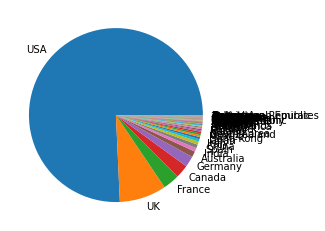

In [53]:
values_counts = df_full["country"].value_counts()

fig1, ax1 = plt.subplots()
ax1.pie(values_counts.values, labels=values_counts.index)
plt.show()

In [54]:
# We see that there is only "USA" and "UK" that represent more than 5%
values_counts = df_full["country"].value_counts(normalize = True)
values_counts = values_counts[values_counts > 0.01]
values_counts

USA          0.757249
UK           0.087200
France       0.030862
Canada       0.024648
Germany      0.020091
Australia    0.010978
Name: country, dtype: float64

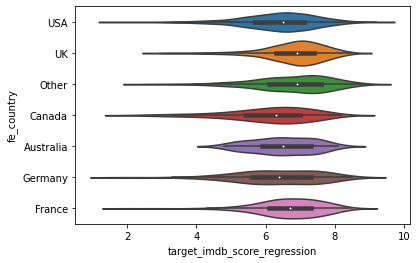

In [55]:
# Group the languages with little occurrences into one category
def get_language(x):
    if(x not in (values_counts)):
        return "Other"
    return x

df_full["fe_country"] = df_full["country"].map(lambda x: get_language(x))

# Visualize the distribution of the IMDB according the the aspect ratio (after grouping small categories)
graph = sns.violinplot(x='target_imdb_score_regression', y='fe_country', data=df_full)

In [56]:
# One hot encore this feature
df_full["fe_country"] = df_full["fe_country"].astype("category")
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df_full[["fe_country"]])

print(f' The categories are: {enc.categories_}')
enc_df = pd.DataFrame(enc.transform(df_full[["fe_country"]]).toarray(),
                     columns = enc.get_feature_names(['fe_is_country'])
                     )
df_full = df_full.join(enc_df)


 The categories are: [array(['Australia', 'Canada', 'France', 'Germany', 'Other', 'UK', 'USA'],
      dtype=object)]


In [57]:
# Now that we have handled this feature, we may delete the raw columns
df_full = df_full.drop(columns=["country"], inplace=False)
df_full = df_full.drop(columns=["fe_country"], inplace=False)

## Explore the feature "genres"

In [58]:
# Compute the missing values
print(f'The number of mission values is: {df_full["genres"].isna().sum()}')
print(f'The proportion of mission values is: {df_full["genres"].isna().mean()}')


The number of mission values is: 0
The proportion of mission values is: 0.0


In [59]:
# Extract the genres from the "genres" complex feature and "multi hot encode" it
s_split = df_full["genres"].map(lambda x: x.replace(" ","").split("|"))
s_flaten = [item for sublist in list(s_split) for item in sublist]
l_distinct = list(set(s_flaten))



In [60]:
# Compute how many genres there are
len(l_distinct)

24

In [61]:
# One hot encode all genres, as there is a limited number 
for element in l_distinct:
    element_cleaned = element.replace("-","_")
    df_full["fe_is_genre_" + element_cleaned] = s_split.map(lambda x: 1 if element in x else 0)


In [62]:
# Now that we have handled this feature, we may delete the raw columns
df_full = df_full.drop(columns=["genres"], inplace=False)

## Explore the feature "plot_keywords"

In [63]:
# Compute the missing values
print(f'The number of mission values is: {df_full["plot_keywords"].isna().sum()}')
print(f'The proportion of mission values is: {df_full["plot_keywords"].isna().mean()}')


The number of mission values is: 121
The proportion of mission values is: 0.025056947608200455


In [64]:
# Fill the empty values with empty string first
df_full["fe_plot_keywords"] = df_full["plot_keywords"].fillna("")

# Extract the genres from the "genres" complex feature and "multi hot encode" it
s_split = df_full["fe_plot_keywords"].map(lambda x: x.replace(" ","").split("|"))
s_flaten = [item for sublist in list(s_split) for item in sublist]
l_distinct = list(set(s_flaten))



In [65]:
# Compute how many plot keywords there are
len(l_distinct)

7880

In [66]:
# Let's keep only plot keywords which come up regularily
value_counts = pd.Series(s_flaten).value_counts()
value_counts = value_counts[value_counts > 50]
value_counts = value_counts[value_counts.index != '']

print(f'The number of kept plot keywords is: {len(value_counts)}')
value_counts.head()

The number of kept plot keywords is: 23


love      196
friend    161
murder    157
death     127
police    117
dtype: int64

In [67]:
# One hot encode all plot words
l_distinct = list(value_counts.index)

for element in l_distinct:
    element_cleaned = element.replace("-","_")
    df_full["fe_is_plot_keywords_" + element_cleaned] = s_split.map(lambda x: 1 if element in x else 0)


In [68]:
# Now that we have handled this feature, we may delete the raw columns
df_full = df_full.drop(columns=["plot_keywords"], inplace=False)
df_full = df_full.drop(columns=["fe_plot_keywords"], inplace=False)

### "director_facebook_likes"

In [69]:
# Compute the missing values
print(f'The number of mission values is: {df_full["director_facebook_likes"].isna().sum()}')
print(f'The proportion of mission values is: {df_full["director_facebook_likes"].isna().mean()}')


The number of mission values is: 0
The proportion of mission values is: 0.0


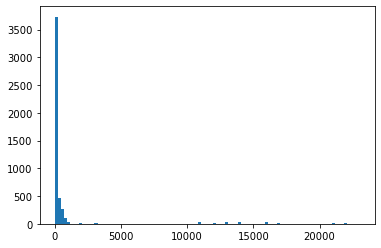

In [70]:
plt.hist(df_full["director_facebook_likes"], bins=100)
plt.show()

In [71]:
# Fill this feature with the median value as it is skewed
df_full["fe_director_facebook_likes"] = df_full["director_facebook_likes"].fillna(
    df_full["director_facebook_likes"].median())

In [72]:
# Now that we have handled this feature, we may delete the raw columns
df_full = df_full.drop(columns=["director_facebook_likes"], inplace=False)

## Explore the feature "actor_1_facebook_likes"

In [73]:
# Compute the missing values
print(f'The number of mission values is: {df_full["actor_1_facebook_likes"].isna().sum()}')
print(f'The proportion of mission values is: {df_full["actor_1_facebook_likes"].isna().mean()}')


The number of mission values is: 7
The proportion of mission values is: 0.001449575481466142


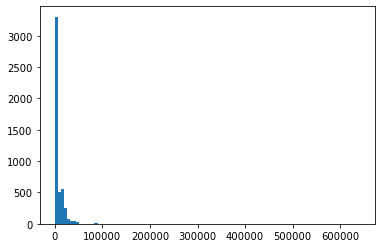

In [74]:
plt.hist(df_full["actor_1_facebook_likes"], bins=100)
plt.show()

In [75]:
# Fill this feature with the median value as it is skewed
df_full["fe_actor_1_facebook_likes"] = df_full["actor_1_facebook_likes"].fillna(
    df_full["actor_1_facebook_likes"].median())

In [76]:
# Now that we have handled this feature, we may delete the raw columns
df_full = df_full.drop(columns=["actor_1_facebook_likes"], inplace=False)

## Explore the feature "actor_2_facebook_likes"

In [77]:
# Compute the missing values
print(f'The number of mission values is: {df_full["actor_2_facebook_likes"].isna().sum()}')
print(f'The proportion of mission values is: {df_full["actor_2_facebook_likes"].isna().mean()}')


The number of mission values is: 10
The proportion of mission values is: 0.0020708221163802027


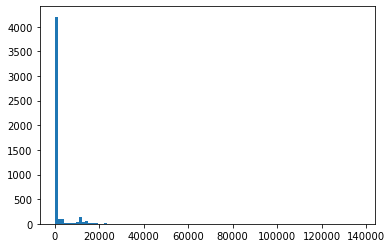

In [78]:
plt.hist(df_full["actor_2_facebook_likes"], bins=100)
plt.show()

In [79]:
# Fill this feature with the median value as it is skewed
df_full["fe_actor_2_facebook_likes"] = df_full["actor_2_facebook_likes"].fillna(
    df_full["actor_2_facebook_likes"].median())

In [80]:
# Now that we have handled this feature, we may delete the raw columns
df_full = df_full.drop(columns=["actor_2_facebook_likes"], inplace=False)

## Explore the feature "actor_3_facebook_likes"

In [81]:
# Compute the missing values
print(f'The number of mission values is: {df_full["actor_3_facebook_likes"].isna().sum()}')
print(f'The proportion of mission values is: {df_full["actor_3_facebook_likes"].isna().mean()}')


The number of mission values is: 18
The proportion of mission values is: 0.003727479809484365


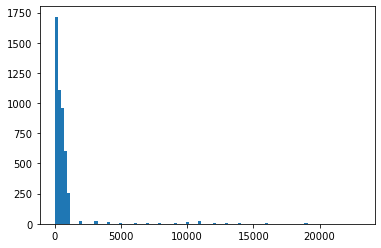

In [82]:
plt.hist(df_full["actor_3_facebook_likes"], bins=100)
plt.show()

In [83]:
# Fill this feature with the median value as it is skewed
df_full["fe_actor_3_facebook_likes"] = df_full["actor_3_facebook_likes"].fillna(
    df_full["actor_3_facebook_likes"].median())

In [84]:
# Now that we have handled this feature, we may delete the raw columns
df_full = df_full.drop(columns=["actor_3_facebook_likes"], inplace=False)

## Combining the features "actor_1_facebook_likes", "actor_2_facebook_likes", "actor_3_facebook_likes"

In [85]:
df_full["fe_actors_facebook_likes_max"] = df_full[[
"fe_actor_1_facebook_likes",
"fe_actor_2_facebook_likes",
"fe_actor_3_facebook_likes",
]].max(axis=1)

df_full["fe_actors_facebook_likes_mean"] = df_full[[
"fe_actor_1_facebook_likes",
"fe_actor_2_facebook_likes",
"fe_actor_3_facebook_likes",
]].mean(axis=1)


## Explore the feature "color"

In [86]:
# Compute the missing values
print(f'The number of mission values is: {df_full["color"].isna().sum()}')
print(f'The proportion of mission values is: {df_full["color"].isna().mean()}')


The number of mission values is: 14
The proportion of mission values is: 0.002899150962932284


In [87]:
# Distribution 
value_counts = df_full["color"].value_counts()
print(f'The number of mission values is: \n{value_counts}')
print(f'The proportion of the highest category to other categories is: {value_counts[0]/sum(value_counts)}')



The number of mission values is: 
Color               4609
 Black and White     206
Name: color, dtype: int64
The proportion of the highest category to other categories is: 0.9572170301142264


In [88]:
# Replace with the majority columns
df_full["fe_color"] = df_full["color"].fillna(df_full["color"].mode()[0])

In [89]:
df_full["fe_is_color"] = df_full["fe_color"].map(lambda x: 1 if x=="Color" else 0)

In [90]:
# Now that we have handled this feature, we may delete the raw columns
df_full = df_full.drop(columns=["color"], inplace=False)
df_full = df_full.drop(columns=["fe_color"], inplace=False)

## Explore the feature "gross"

In [91]:
# Compute the missing values
print(f'The number of mission values is: {df_full["gross"].isna().sum()}')
print(f'The proportion of mission values is: {df_full["gross"].isna().mean()}')


The number of mission values is: 747
The proportion of mission values is: 0.15469041209360115


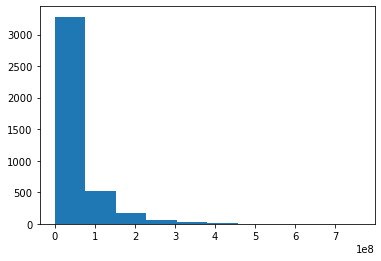

In [92]:
plt.hist(df_full["gross"])
plt.show()

In [93]:
# Fill this feature with the median value as it is skewed
df_full["fe_gross"] = df_full["gross"].fillna(df_full["gross"].median())

In [94]:
# Now that we have handled this feature, we may delete the raw columns
df_full = df_full.drop(columns=["gross"], inplace=False)

## Explore the feature "duration"

In [95]:
# Compute the missing values
print(f'The number of mission values is: {df_full["duration"].isna().sum()}')
print(f'The proportion of mission values is: {df_full["duration"].isna().mean()}')


The number of mission values is: 12
The proportion of mission values is: 0.0024849865396562435


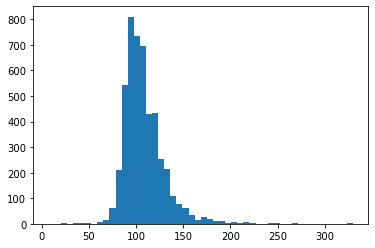

In [96]:
plt.hist(df_full["duration"], bins=50)
plt.show()

In [97]:
# Fill this feature with the median value as it has a bell curve
df_full["fe_duration"] = df_full["duration"].fillna(df_full["duration"].mean())

In [98]:
# Now that we have handled this feature, we may delete the raw columns
df_full = df_full.drop(columns=["duration"], inplace=False)

## Take into account other clean features

In [99]:
# Keep other clean columns unchanged
df_full = df_full.rename(columns={
    "num_voted_users": "fe_num_voted_users", 
    "cast_total_facebook_likes": "fe_cast_total_facebook_likes",
    "movie_facebook_likes": "fe_movie_facebook_likes",
})

In [100]:
# Keep the movie title as being the id
df_full = df_full.rename(columns={
    "movie_title": "id_movie_title",
})

## Delete unused columns 

In [101]:
# Keep other clean columns unchanged
df_full = df_full.drop(columns=[
    "director_name",
    "actor_1_name",
    "actor_2_name",
    "actor_3_name",
    "movie_imdb_link",
], inplace=False)

## Explore correlations between continuous features

In [102]:
# n'oublie pas de faire un heatmap pour exclure les var corrélées entre elles
col_continuous = [
    'fe_actors_facebook_likes_max',
    'fe_actors_facebook_likes_mean',
    'fe_budget_log',
    'fe_cast_total_facebook_likes',
    'fe_director_facebook_likes',
    'fe_duration',
    'fe_facenumber_in_poster',
    'fe_gross',
    'fe_movie_facebook_likes',
    'fe_num_critic_for_reviews',
    'fe_num_user_for_reviews',
    'fe_num_voted_users',
    'fe_title_year_grouped',
    'target_imdb_score_classification',
]

<AxesSubplot:>

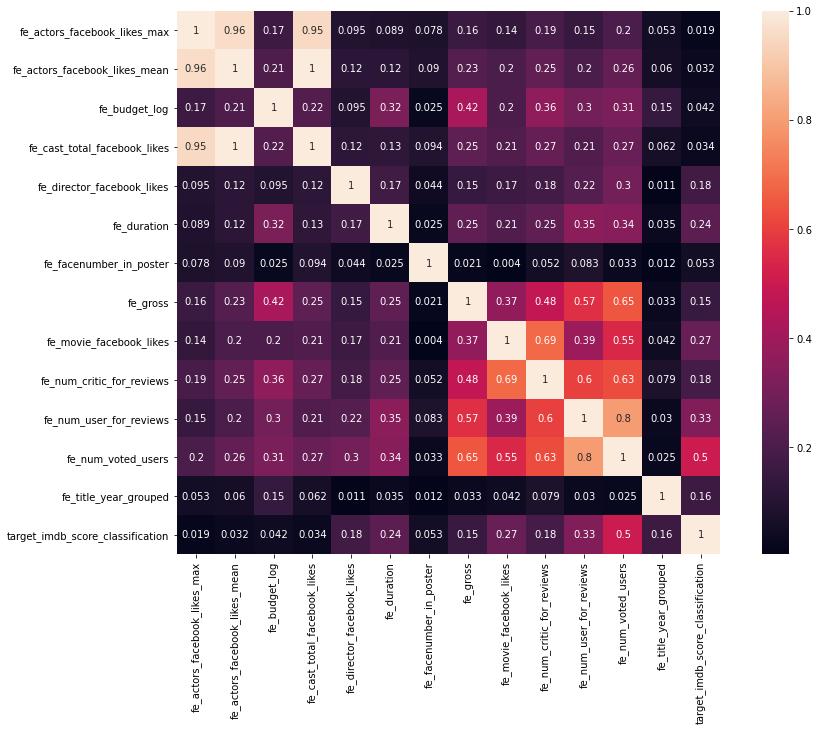

In [103]:
# Draw the heatmap that shows the correlation between each pair of variables
# We observe that only few features show some correlation with the target:
# "fe_num_user_for_reviews", "fe_num_voted_users" and "fe_movie_facebook_likes"
corr_mat = df_full[col_continuous].corr()
corr_mat = abs(corr_mat)

fig,ax= plt.subplots()
fig.set_size_inches(15,10)
sns.heatmap(corr_mat, square=True, annot=True)

# Model training and evaluation
In this part, we are applying machine learning in order to estimate what precision we can reach.
Note that as we are using the whole dataset we are training and evaluating the models using cross validation. 
That way, we ara preventing data leakage (although it would have been better to split the data at the beginning).

In [130]:
# Prepare the X (matrix of features) and y (the target vector)
features_columns = [col for col in df_full.columns if col.startswith("fe_")]
features_columns.sort()

target_reg_column = "target_imdb_score_regression"
target_class_column = "target_imdb_score_classification"
id_column = "id_movie_title"

X_train = df_full[features]
y_train = df_full[target_classification]


In [105]:
# Apply grid search to find a good preliminary hyperparameters configuration
# We have chosen RandomForest for this use case
def custom_scoring(y_true, y_pred):
    return f1_score(y_true, y_pred, zero_division=0)

model = RandomForestClassifier()
hyperparameters = {
    "n_estimators": [100],
    "min_samples_split": [4, 8, 16],
    "min_samples_leaf": [4, 8, 16],
    "max_depth": [4, 8, 16],
}

grid = GridSearchCV(model, param_grid=hyperparameters, cv=5, 
                    scoring=make_scorer(custom_scoring, greater_is_better=True))
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)


{'max_depth': 16, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 100}
0.4621763726707302


In [152]:
# Here, we have 2 function that will compute the precision that can be reached by our model
# but with a minimum recall required
def cross_validate(
    model, 
    df_full: pd.DataFrame,
    features_columns: List[str],
    target_reg_column: str,
    target_class_column: str,
    number_splits: int = 5,
    min_recall: float = 0.1) -> Tuple[float, float, float]:

    # First, extract the classification target 
    #...(and let the X and y for the regression, as we are applying regression in this study)
    X_and_y = df_full[features_columns + [target_reg_column]].values
    y_class = df_full[target_class_column].values

    # Theses lists will contain the evaluations of each folds
    list_thresholds = []
    list_precision = []
    list_recall = []

    # Split stratified-wise
    stratified_k_fold = StratifiedKFold(n_splits=number_splits, shuffle=True)
    index_pairs_folds = stratified_k_fold.split(X_and_y, y_class)

    # For each fold, get the indexes of the train and test dataset
    for index_train, index_test in index_pairs_folds:
        #  Get the train and test dataset, from their indexes
        df_train = df_full.iloc[index_train]
        df_test = df_full.iloc[index_test]

        # First, extract the classification target
        X_train_and_y_train_reg_true = df_train[features_columns + [target_reg_column]]
        y_train_class_true = df_train[target_class_column]        
        X_test_and_y_test_reg_true = df_test[features_columns + [target_reg_column]]
        y_test_class_true = df_test[target_class_column]

        # Apply a resampling for the train dataset
        sampler_adasyn = ADASYN(random_state=12)
        X_train_and_y_train_reg_true_resampled, y_train_class_true_resampled = sampler_adasyn.fit_sample(
            X_train_and_y_train_reg_true, y_train_class_true)

        # Second, extract the regression target: we come up with X and y for train and test!
        # We are finally ready for the model traing
        X_train_resampled = X_train_and_y_train_reg_true_resampled[features_columns]
        y_train_reg_true_resampled = X_train_and_y_train_reg_true_resampled[target_reg_column]
        X_test = X_test_and_y_test_reg_true[features_columns]
        y_test_reg_true = X_test_and_y_test_reg_true[target_reg_column]

        # Run the model (with the resampled X and y train)
        model.fit(X_train_resampled, y_train_reg_true_resampled)

        # Get the predictions
        y_test_reg_pred = model.predict(X_test)

        # Compute the following metrics of this fold (with regards to the min_recall required)
        # ...See the "optimize_threshold_for_precision" function below
        threshold, precision, recall = optimize_threshold_for_precision(
            df_test, 
            y_test_class_true, 
            y_test_reg_pred, 
            np.arange(7.1, 10.0, 0.01),
            min_recall)

        print(f'Best metrics for this fold are '+
            f'Threshold: {round(threshold, 1)}, Precision: {round(precision, 3)}, Recall: {round(recall, 3)}')

        list_thresholds.append(threshold)
        list_precision.append(precision)
        list_recall.append(recall)

    # Compute the average of each metric
    mean_threshold = round(float(np.mean(list_thresholds)), 1)
    mean_precision = round(float(np.mean(list_precision)), 3)
    mean_recall = round(float(np.mean(list_recall)), 3)

    print(f'Final mean results are '+
        f'Threshold: {mean_threshold}, Precision: {mean_precision}, Recall: {mean_recall}')

    return mean_threshold, mean_precision, mean_recall

# This function computes the metric, it takes as input the true classes, the predicted classes, and the min recall required
def optimize_threshold_for_precision(
    df_test: pd.DataFrame,
    y_test_class_true: np.ndarray, 
    y_test_reg_pred: np.ndarray,
    threshold_range: Iterable[float], 
    min_recall: float) -> Tuple[float, int, float, int]:
 
    best_precision = 0.
    recall_for_best_precision = 0.
    threshold_for_best_precision = 0.

    # In order to compute the best metrics (with regards to the min recall required), we make the threshold vary
    for threshold in threshold_range:
        # First, compute the predicted classes (thanks to the threshold)
        y_test_class_pred = np.where(y_test_reg_pred >= threshold, 1, 0)

        # Get the metrics
        regression_precision = precision_score(y_test_class_true, y_test_class_pred, zero_division=0)
        regression_recall = recall_score(y_test_class_true, y_test_class_pred, zero_division=0)

        # If the precision is better, and we still have the required recall, save the metrics
        if regression_precision > best_precision and regression_recall > min_recall:
            best_precision = regression_precision
            recall_for_best_precision = regression_recall
            threshold_for_best_precision = threshold
        elif regression_precision == best_precision and regression_recall > min_recall:
            recall_for_best_precision = regression_recall
            threshold_for_best_precision = threshold

    return threshold_for_best_precision, best_precision, recall_for_best_precision

In [153]:
# Use a model with the best hyperparameters found by the grid search
model = RandomForestRegressor(**grid.best_params_)

# Call the function that computes the precision
# ... We are requiring a minimum of 50% recall, that is we want the model to keep 50% of the good movies
mean_threshold, mean_precision, mean_recall = cross_validate(
  model, 
  df_full, 
  features_columns, 
  target_reg_column, 
  target_class_column,
  number_splits = 5,
  min_recall = 0.5)

Best metrics for this fold are Threshold: 8.0, Precision: 0.935, Recall: 0.509
Best metrics for this fold are Threshold: 7.8, Precision: 0.667, Recall: 0.526
Best metrics for this fold are Threshold: 8.0, Precision: 0.912, Recall: 0.544
Best metrics for this fold are Threshold: 7.9, Precision: 0.707, Recall: 0.509
Best metrics for this fold are Threshold: 7.8, Precision: 0.8, Recall: 0.561
Final mean results are Threshold: 7.9, Precision: 0.804, Recall: 0.53


# Conclusion
We have finally come up with a model that will keep 50% of the good movies (recall >= 0.5).
For that requirement, we have to keep all movies which ratings will be predicted to be more than 7.9 (threshold).
And we obtain a precision of more that 80%, which means that 4 times over 5, we will have a good time watching a nice movie!